# Cut-replace rate: how much is a sentence cut vs. replaced

## 1 Setup

Flags

In [1]:
# None

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_3


In [3]:
import random
import itertools

import numpy as np
from scipy import optimize
from nltk.metrics import edit_distance
from frozendict import frozendict
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from progressbar import ProgressBar

from gists.models import Sentence
from analysis import settings, transformations

## 2 Test optimising for known parameters

### 2.1 Framework setup

In [4]:
kept_sentence_ids = Sentence.objects.kept\
    .filter(parent__isnull=False)\
    .values_list('id', flat=True)
kept_sentence_ids = list(kept_sentence_ids)

def sample_training_sentences(sample_size):
    remaining_shuffled_sentence_ids = random.sample(kept_sentence_ids, len(kept_sentence_ids))
    sample_sentences = []
    while len(sample_sentences) < sample_size:
        candidate = Sentence.objects.get(id=remaining_shuffled_sentence_ids.pop())
        if candidate.oc_distance(candidate.parent) > 0:
            sample_sentences.append(candidate)
    assert len(sample_sentences) == sample_size
    return sample_sentences

def get_complement_test_sentences(sample_sentences):
    test_sentences = []
    for sid in set(kept_sentence_ids).difference(
            [sentence.id for sentence in sample_sentences]):
        candidate = Sentence.objects.get(id=sid)
        if candidate.oc_distance(candidate.parent) > 0:
            test_sentences.append(candidate)
    return test_sentences

In [5]:
def alignments(sentences, parameters):
    frozen_parameters = frozendict(parameters)
    return [transformations.align_lemmas(s.parent.tokens, s.tokens,
                                         parameters=frozen_parameters)
            for s in sentences]

In [6]:
def distance(alignment1, alignment2):
    seq1A, seq1B = alignment1[:2]
    seq2A, seq2B = alignment2[:2]
    seq1A = list(map(id, seq1A))
    seq1B = list(map(id, seq1B))
    seq2A = list(map(id, seq2A))
    seq2B = list(map(id, seq2B))
    return (edit_distance(seq1A, seq2A) + edit_distance(seq1B, seq2B)) / 2

In [7]:
BASE_COMPARE_FACTOR = 1
def x2parameters(x):
    return frozendict({
        'COMPARE_FACTOR': BASE_COMPARE_FACTOR,
        'COMPARE_ORIGIN': x[0] * BASE_COMPARE_FACTOR,
        'GAP_OPEN': (x[1] + x[2]) * BASE_COMPARE_FACTOR,
        'GAP_EXTEND': x[2] * BASE_COMPARE_FACTOR,
        'EXCHANGE': None,
    })

def parameters2x(parameters):
    return (np.array([parameters['COMPARE_ORIGIN'],
                      parameters['GAP_OPEN'] - parameters['GAP_EXTEND'],
                      parameters['GAP_EXTEND']])
            / parameters['COMPARE_FACTOR'])

In [8]:
def objective(x, sentences, ref_alignments):
    x_alignments = alignments(sentences, x2parameters(x))
    distances = []
    for ref_as, x_as in zip(ref_alignments, x_alignments):
        if len(x_as) == 0:
            # Add an empty alignment if there are none
            x_as = [([], [])]
        # Or use max+mean
        distances.append(np.max([distance(ref_a, x_a) for ref_a, x_a
                                 in itertools.zip_longest(ref_as,  x_as,
                                                          fillvalue=([], []))]))
    return np.sum(distances)

In [9]:
reference_parameters = {
    'COMPARE_FACTOR': BASE_COMPARE_FACTOR,
    'COMPARE_ORIGIN': -.5,
    'GAP_OPEN': -.5,
    'GAP_EXTEND': -.1,
    'EXCHANGE': None,
}

x_bounds = [
    (-1, -.01), # COMPARE_ORIGIN / COMPARE_FACTOR
    (-1, -.01), # (GAP_OPEN - GAP_EXTEND) / COMPARE_FACTOR
    (-1, -.01), # GAP_EXTEND / COMPARE_FACTOR
]

### 2.2 Local optimisation

In [10]:
sample_sentences = sample_training_sentences(200)
reference_alignments = alignments(sample_sentences, reference_parameters)
for _ in range(1):
    x0 = [np.random.uniform(*bounds) for bounds in x_bounds]
    result = optimize.minimize(
        objective, x0,
        #method='SLSQP',
        bounds=x_bounds,
        args=(sample_sentences, reference_alignments),
        options={'disp': True, 'maxiter': 500},
        callback=print)
    print(result)
    print(x2parameters(result.x))
    print()
    print()

      fun: 187.5
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.,  0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
   status: 0
  success: True
        x: array([-0.81247674, -0.97390607, -0.43544459])
<frozendict {'COMPARE_FACTOR': 1, 'COMPARE_ORIGIN': -0.81247673764873696, 'GAP_OPEN': -1.4093506624563685, 'GAP_EXTEND': -0.43544458809881204, 'EXCHANGE': None}>




### 2.3 Brute force

Try plotting one sample size

100% (1000 of 1000) |#####################| Elapsed Time: 0:01:32 Time: 0:01:32


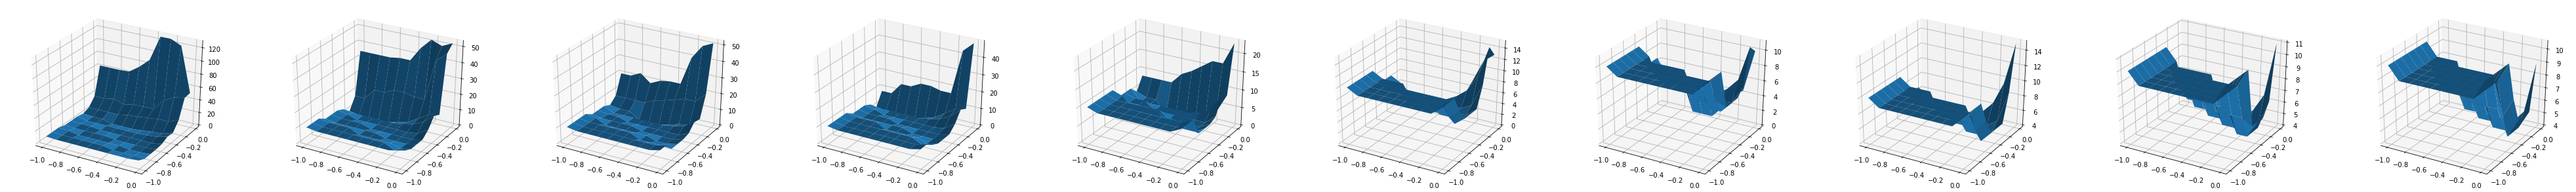

In [11]:
discretization = 10
n_dims = len(x_bounds)
xs = [np.linspace(start, stop, discretization) for (start, stop) in x_bounds]
grids = np.meshgrid(*xs, indexing='ij')
values = np.zeros_like(grids[0])

sample_sentences = sample_training_sentences(20)
reference_alignments = alignments(sample_sentences, reference_parameters)
for i, k in ProgressBar(max_value=len(values.flat))(
        enumerate(itertools.product(range(discretization), repeat=n_dims))):
    values[k] = objective([grids[j][k] for j in range(n_dims)],
                          sample_sentences, reference_alignments)

fig, axes = plt.subplots(1, discretization,
                         figsize=(70, 5), subplot_kw={'projection': '3d'})
for i in range(discretization):
    axes[i].plot_surface(grids[1][i, :, :], grids[2][i, :, :], values[i, :, :])

Then evaluate several sizes

In [12]:
def evaluate_sample_size(sample_size, xref=parameters2x(reference_parameters)):
    n_runs = 10
    print()
    print('Sample size {}, doing {} runs'.format(sample_size, n_runs))
    
    worst_objectives = []
    for r in range(n_runs):
        print()
        print('Run', r)
        
        # Brute force the parameter fitting
        discretization = 10
        n_dims = len(x_bounds)
        xs = [np.linspace(start, stop, discretization) for (start, stop) in x_bounds]
        grids = np.meshgrid(*xs, indexing='ij')
        values = np.zeros_like(grids[0])
        
        sample_sentences = sample_training_sentences(sample_size)
        reference_alignments = alignments(sample_sentences, x2parameters(xref))
        for i, k in ProgressBar(max_value=len(values.flat))(
                enumerate(itertools.product(range(discretization), repeat=n_dims))):
            values[k] = objective([grids[j][k] for j in range(n_dims)],
                                  sample_sentences, reference_alignments)
        
        min_value = np.min(values)
        min_locations = np.where(values == min_value)
        print('Min training objective value {}, found in {} points'
              .format(min_value, len(min_locations[0])))
        
        # Test the best parameters found
        test_sentences = get_complement_test_sentences(sample_sentences)
        print('Testing on the remaining {} sentences'.format(len(test_sentences)))
        test_alignments = alignments(test_sentences, x2parameters(xref))
        objective_values = []
        for k in zip(*min_locations):
            x = [grids[0][k], grids[1][k], grids[2][k]]
            objective_values.append(objective(x, test_sentences, test_alignments))
        print('Worst objective', np.max(objective_values))
        worst_objectives.append(np.max(objective_values))
    
    print()
    print('Overall worst objective for {} runs of sample size {} = {}'
          .format(n_runs, sample_size, np.max(worst_objectives)))
    return np.max(worst_objectives)

In [13]:
evaluate_sample_size(20)


Sample size 20, doing 10 runs

Run 0


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:22 Time: 0:02:22


Min training objective value 0.0, found in 4 points
Testing on the remaining 2139 sentences


  0% (1 of 1000) |                         | Elapsed Time: 0:00:00 ETA: 0:01:48

Worst objective 350.5

Run 1


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:41 Time: 0:01:41


Min training objective value 0.0, found in 52 points
Testing on the remaining 2139 sentences


  0% (1 of 1000) |                         | Elapsed Time: 0:00:00 ETA: 0:02:16

Worst objective 2001.5

Run 2


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:15 Time: 0:02:15


Min training objective value 0.0, found in 63 points
Testing on the remaining 2139 sentences


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Worst objective 2076.0

Run 3


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:28 Time: 0:02:28


Min training objective value 0.0, found in 17 points
Testing on the remaining 2139 sentences
Worst objective 1935.0

Run 4


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:51 Time: 0:01:51


Min training objective value 1.0, found in 215 points
Testing on the remaining 2139 sentences


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Worst objective 2278.0

Run 5


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:01 Time: 0:02:01


Min training objective value 0.0, found in 211 points
Testing on the remaining 2139 sentences


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Worst objective 2195.0

Run 6


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:07 Time: 0:02:07


Min training objective value 0.0, found in 8 points
Testing on the remaining 2139 sentences


  0% (1 of 1000) |                         | Elapsed Time: 0:00:00 ETA: 0:02:16

Worst objective 854.5

Run 7


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:34 Time: 0:01:34


Min training objective value 0.0, found in 37 points
Testing on the remaining 2139 sentences


  0% (1 of 1000) |                         | Elapsed Time: 0:00:00 ETA: 0:01:43

Worst objective 3652.5

Run 8


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:18 Time: 0:01:18


Min training objective value 1.0, found in 7 points
Testing on the remaining 2139 sentences


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Worst objective 795.0

Run 9


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:06 Time: 0:01:06


Min training objective value 0.0, found in 270 points
Testing on the remaining 2139 sentences
Worst objective 2559.0

Overall worst objective for 10 runs of sample size 20 = 3652.5


3652.5

In [14]:
evaluate_sample_size(50)


Sample size 50, doing 10 runs

Run 0


100% (1000 of 1000) |#####################| Elapsed Time: 0:03:22 Time: 0:03:22


Min training objective value 0.0, found in 4 points
Testing on the remaining 2109 sentences


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Worst objective 649.5

Run 1


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:52 Time: 0:02:52


Min training objective value 0.0, found in 7 points
Testing on the remaining 2109 sentences


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Worst objective 872.0

Run 2


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:52 Time: 0:02:52


Min training objective value 0.0, found in 4 points
Testing on the remaining 2109 sentences


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Worst objective 561.5

Run 3


100% (1000 of 1000) |#####################| Elapsed Time: 0:03:01 Time: 0:03:01


Min training objective value 1.0, found in 4 points
Testing on the remaining 2109 sentences


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Worst objective 648.5

Run 4


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:33 Time: 0:02:33


Min training objective value 3.0, found in 7 points
Testing on the remaining 2109 sentences


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Worst objective 793.0

Run 5


100% (1000 of 1000) |#####################| Elapsed Time: 0:03:22 Time: 0:03:22


Min training objective value 55.0, found in 34 points
Testing on the remaining 2109 sentences


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Worst objective 1377.5

Run 6


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:37 Time: 0:02:37


Min training objective value 0.0, found in 4 points
Testing on the remaining 2109 sentences


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Worst objective 561.5

Run 7


100% (1000 of 1000) |#####################| Elapsed Time: 0:03:05 Time: 0:03:05


Min training objective value 0.0, found in 8 points
Testing on the remaining 2109 sentences


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Worst objective 718.5

Run 8


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:57 Time: 0:01:57


Min training objective value 2.0, found in 4 points
Testing on the remaining 2109 sentences


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Worst objective 647.5

Run 9


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:28 Time: 0:02:28


Min training objective value 22.0, found in 4 points
Testing on the remaining 2109 sentences
Worst objective 328.5

Overall worst objective for 10 runs of sample size 50 = 1377.5


1377.5

In [15]:
evaluate_sample_size(100)


Sample size 100, doing 10 runs

Run 0


100% (1000 of 1000) |#####################| Elapsed Time: 0:04:21 Time: 0:04:21


Min training objective value 8.0, found in 4 points
Testing on the remaining 2059 sentences
Worst objective 342.5

Run 1


100% (1000 of 1000) |#####################| Elapsed Time: 0:05:24 Time: 0:05:24


Min training objective value 9.0, found in 4 points
Testing on the remaining 2059 sentences
Worst objective 640.5

Run 2


100% (1000 of 1000) |#####################| Elapsed Time: 0:04:46 Time: 0:04:46


Min training objective value 7.5, found in 8 points
Testing on the remaining 2059 sentences
Worst objective 847.0

Run 3


100% (1000 of 1000) |#####################| Elapsed Time: 0:04:18 Time: 0:04:18


Min training objective value 9.0, found in 4 points
Testing on the remaining 2059 sentences
Worst objective 341.5

Run 4


100% (1000 of 1000) |#####################| Elapsed Time: 0:05:01 Time: 0:05:01


Min training objective value 2.5, found in 4 points
Testing on the remaining 2059 sentences
Worst objective 647.0

Run 5


100% (1000 of 1000) |#####################| Elapsed Time: 0:05:03 Time: 0:05:03


Min training objective value 1.0, found in 16 points
Testing on the remaining 2059 sentences
Worst objective 717.5

Run 6


100% (1000 of 1000) |#####################| Elapsed Time: 0:04:14 Time: 0:04:14


Min training objective value 0.0, found in 4 points
Testing on the remaining 2059 sentences
Worst objective 561.5

Run 7


100% (1000 of 1000) |#####################| Elapsed Time: 0:05:34 Time: 0:05:34


Min training objective value 9.0, found in 4 points
Testing on the remaining 2059 sentences
Worst objective 341.5

Run 8


100% (1000 of 1000) |#####################| Elapsed Time: 0:04:03 Time: 0:04:03


Min training objective value 2.0, found in 4 points
Testing on the remaining 2059 sentences
Worst objective 348.5

Run 9


100% (1000 of 1000) |#####################| Elapsed Time: 0:03:35 Time: 0:03:35


Min training objective value 1.0, found in 4 points
Testing on the remaining 2059 sentences
Worst objective 648.5

Overall worst objective for 10 runs of sample size 100 = 847.0


847.0

In [16]:
evaluate_sample_size(200)


Sample size 200, doing 10 runs

Run 0


100% (1000 of 1000) |#####################| Elapsed Time: 0:08:25 Time: 0:08:25


Min training objective value 31.5, found in 4 points
Testing on the remaining 1959 sentences
Worst objective 319.0

Run 1


100% (1000 of 1000) |#####################| Elapsed Time: 0:08:09 Time: 0:08:09


Min training objective value 50.0, found in 4 points
Testing on the remaining 1959 sentences
Worst objective 300.5

Run 2


100% (1000 of 1000) |#####################| Elapsed Time: 0:06:42 Time: 0:06:42


Min training objective value 33.5, found in 4 points
Testing on the remaining 1959 sentences
Worst objective 616.0

Run 3


100% (1000 of 1000) |#####################| Elapsed Time: 0:06:17 Time: 0:06:17


Min training objective value 13.0, found in 4 points
Testing on the remaining 1959 sentences
Worst objective 636.5

Run 4


100% (1000 of 1000) |#####################| Elapsed Time: 0:07:23 Time: 0:07:23


Min training objective value 69.0, found in 4 points
Testing on the remaining 1959 sentences
Worst objective 281.5

Run 5


100% (1000 of 1000) |#####################| Elapsed Time: 0:06:16 Time: 0:06:16


Min training objective value 13.5, found in 4 points
Testing on the remaining 1959 sentences
Worst objective 548.0

Run 6


100% (1000 of 1000) |#####################| Elapsed Time: 0:05:44 Time: 0:05:44


Min training objective value 53.5, found in 4 points
Testing on the remaining 1959 sentences
Worst objective 297.0

Run 7


100% (1000 of 1000) |#####################| Elapsed Time: 0:05:48 Time: 0:05:48


Min training objective value 46.5, found in 4 points
Testing on the remaining 1959 sentences
Worst objective 304.0

Run 8


100% (1000 of 1000) |#####################| Elapsed Time: 0:06:08 Time: 0:06:08


Min training objective value 13.0, found in 4 points
Testing on the remaining 1959 sentences
Worst objective 548.5

Run 9


100% (1000 of 1000) |#####################| Elapsed Time: 0:04:43 Time: 0:04:43


Min training objective value 14.0, found in 4 points
Testing on the remaining 1959 sentences
Worst objective 336.5

Overall worst objective for 10 runs of sample size 200 = 636.5


636.5

In [17]:
gold100_worst_objectives = []
gold100_n_runs = 10
for i in range(gold100_n_runs):
    xref = [np.random.uniform(*bounds) for bounds in x_bounds]
    gold100_worst_objectives.append(evaluate_sample_size(100, xref))


Sample size 100, doing 10 runs

Run 0


100% (1000 of 1000) |#####################| Elapsed Time: 0:03:10 Time: 0:03:10


Min training objective value 0.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 269.5

Run 1


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:14 Time: 0:02:14


Min training objective value 0.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 332.5

Run 2


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:13 Time: 0:02:13


Min training objective value 4.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 349.5

Run 3


100% (1000 of 1000) |#####################| Elapsed Time: 0:03:22 Time: 0:03:22


Min training objective value 31.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 238.5

Run 4


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:45 Time: 0:02:45


Min training objective value 0.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 269.5

Run 5


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:19 Time: 0:02:19


Min training objective value 2.5, found in 9 points
Testing on the remaining 2059 sentences
Worst objective 553.0

Run 6


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:37 Time: 0:02:37


Min training objective value 1.5, found in 9 points
Testing on the remaining 2059 sentences
Worst objective 554.0

Run 7


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:34 Time: 0:02:34


Min training objective value 4.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 265.5

Run 8


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:36 Time: 0:02:36


Min training objective value 0.0, found in 30 points
Testing on the remaining 2059 sentences
Worst objective 575.0

Run 9


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:16 Time: 0:02:16


Min training objective value 0.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 332.5

Overall worst objective for 10 runs of sample size 100 = 575.0

Sample size 100, doing 10 runs

Run 0


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:25 Time: 0:02:25


Min training objective value 0.0, found in 25 points
Testing on the remaining 2059 sentences
Worst objective 422.0

Run 1


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:14 Time: 0:02:14


Min training objective value 21.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 225.5

Run 2


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:17 Time: 0:02:17


Min training objective value 0.0, found in 15 points
Testing on the remaining 2059 sentences
Worst objective 246.5

Run 3


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:31 Time: 0:02:31


Min training objective value 31.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 185.5

Run 4


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:12 Time: 0:02:12


Min training objective value 0.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 177.5

Run 5


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:53 Time: 0:01:53


Min training objective value 0.0, found in 15 points
Testing on the remaining 2059 sentences
Worst objective 216.5

Run 6


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:54 Time: 0:01:54


Min training objective value 21.0, found in 30 points
Testing on the remaining 2059 sentences
Worst objective 500.0

Run 7


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:19 Time: 0:02:19


Min training objective value 0.0, found in 20 points
Testing on the remaining 2059 sentences
Worst objective 341.5

Run 8


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:10 Time: 0:02:10


Min training objective value 5.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 206.0

Run 9


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:00 Time: 0:02:00


Min training objective value 0.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 177.5

Overall worst objective for 10 runs of sample size 100 = 500.0

Sample size 100, doing 10 runs

Run 0


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:36 Time: 0:02:36


Min training objective value 18.0, found in 4 points
Testing on the remaining 2059 sentences
Worst objective 465.5

Run 1


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:52 Time: 0:01:52


Min training objective value 0.0, found in 14 points
Testing on the remaining 2059 sentences
Worst objective 460.5

Run 2


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:05 Time: 0:02:05


Min training objective value 5.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 580.5

Run 3


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:17 Time: 0:02:17


Min training objective value 0.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 257.5

Run 4


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:05 Time: 0:02:05


Min training objective value 6.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 251.5

Run 5


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:18 Time: 0:02:18


Min training objective value 13.0, found in 4 points
Testing on the remaining 2059 sentences
Worst objective 682.5

Run 6


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:57 Time: 0:01:57


Min training objective value 6.0, found in 4 points
Testing on the remaining 2059 sentences
Worst objective 362.0

Run 7


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:16 Time: 0:02:16


Min training objective value 16.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 469.0

Run 8


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:00 Time: 0:02:00


Min training objective value 19.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 238.5

Run 9


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:54 Time: 0:02:54


Min training objective value 14.5, found in 4 points
Testing on the remaining 2059 sentences
Worst objective 469.0

Overall worst objective for 10 runs of sample size 100 = 682.5

Sample size 100, doing 10 runs

Run 0


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:22 Time: 0:02:22


Min training objective value 16.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 322.5

Run 1


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:45 Time: 0:01:45


Min training objective value 2.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 469.5

Run 2


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:57 Time: 0:01:57


Min training objective value 4.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 334.5

Run 3


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:12 Time: 0:02:12


Min training objective value 2.0, found in 4 points
Testing on the remaining 2059 sentences
Worst objective 227.0

Run 4


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:51 Time: 0:01:51


Min training objective value 2.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 336.5

Run 5


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:41 Time: 0:01:41


Min training objective value 8.0, found in 9 points
Testing on the remaining 2059 sentences
Worst objective 840.5

Run 6


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:45 Time: 0:01:45


Min training objective value 2.5, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 336.0

Run 7


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:08 Time: 0:02:08


Min training objective value 2.0, found in 4 points
Testing on the remaining 2059 sentences
Worst objective 227.0

Run 8


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:14 Time: 0:02:14


Min training objective value 13.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 1066.0

Run 9


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:43 Time: 0:01:43


Min training objective value 6.5, found in 4 points
Testing on the remaining 2059 sentences
Worst objective 222.5

Overall worst objective for 10 runs of sample size 100 = 1066.0

Sample size 100, doing 10 runs

Run 0


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:56 Time: 0:01:56


Min training objective value 0.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 253.5

Run 1


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:01 Time: 0:02:01


Min training objective value 0.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 216.0

Run 2


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:02 Time: 0:02:02


Min training objective value 0.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 253.5

Run 3


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:08 Time: 0:02:08


Min training objective value 35.5, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 122.0

Run 4


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:31 Time: 0:01:31


Min training objective value 2.0, found in 15 points
Testing on the remaining 2059 sentences
Worst objective 197.5

Run 5


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:09 Time: 0:02:09


Min training objective value 1.5, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 198.0

Run 6


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:05 Time: 0:02:05


Min training objective value 0.0, found in 15 points
Testing on the remaining 2059 sentences
Worst objective 199.5

Run 7


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:45 Time: 0:01:45


Min training objective value 0.0, found in 15 points
Testing on the remaining 2059 sentences
Worst objective 308.0

Run 8


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:36 Time: 0:01:36


Min training objective value 0.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 216.0

Run 9


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:45 Time: 0:01:45


Min training objective value 2.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 155.5

Overall worst objective for 10 runs of sample size 100 = 308.0

Sample size 100, doing 10 runs

Run 0


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:02 Time: 0:02:02


Min training objective value 2.5, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 151.0

Run 1


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:54 Time: 0:01:54


Min training objective value 0.0, found in 15 points
Testing on the remaining 2059 sentences
Worst objective 157.5

Run 2


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:46 Time: 0:01:46


Min training objective value 0.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 95.0

Run 3


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:05 Time: 0:02:05


Min training objective value 3.0, found in 74 points
Testing on the remaining 2059 sentences
Worst objective 446.0

Run 4


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:37 Time: 0:01:37


Min training objective value 0.0, found in 40 points
Testing on the remaining 2059 sentences
Worst objective 454.0

Run 5


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:53 Time: 0:01:53


Min training objective value 3.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 171.0

Run 6


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:50 Time: 0:01:50


Min training objective value 0.0, found in 15 points
Testing on the remaining 2059 sentences
Worst objective 173.0

Run 7


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:48 Time: 0:01:48


Min training objective value 0.0, found in 30 points
Testing on the remaining 2059 sentences
Worst objective 355.0

Run 8


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:37 Time: 0:01:37


Min training objective value 0.0, found in 20 points
Testing on the remaining 2059 sentences
Worst objective 168.0

Run 9


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:24 Time: 0:02:24


Min training objective value 0.0, found in 15 points
Testing on the remaining 2059 sentences
Worst objective 173.0

Overall worst objective for 10 runs of sample size 100 = 454.0

Sample size 100, doing 10 runs

Run 0


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:20 Time: 0:02:20


Min training objective value 59.5, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 866.5

Run 1


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:42 Time: 0:01:42


Min training objective value 0.0, found in 14 points
Testing on the remaining 2059 sentences
Worst objective 504.0

Run 2


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:47 Time: 0:01:47


Min training objective value 31.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 168.0

Run 3


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:58 Time: 0:01:58


Min training objective value 2.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 197.0

Run 4


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:48 Time: 0:01:48


Min training objective value 0.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 493.5

Run 5


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:12 Time: 0:02:12


Min training objective value 0.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 199.0

Run 6


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:36 Time: 0:01:36


Min training objective value 0.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 199.0

Run 7


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:38 Time: 0:01:38


Min training objective value 0.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 504.0

Run 8


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:00 Time: 0:02:00


Min training objective value 34.5, found in 4 points
Testing on the remaining 2059 sentences
Worst objective 1437.5

Run 9


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:45 Time: 0:01:45


Min training objective value 3.5, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 614.0

Overall worst objective for 10 runs of sample size 100 = 1437.5

Sample size 100, doing 10 runs

Run 0


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:52 Time: 0:01:52


Min training objective value 1.0, found in 15 points
Testing on the remaining 2059 sentences
Worst objective 350.0

Run 1


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:41 Time: 0:01:41


Min training objective value 8.0, found in 15 points
Testing on the remaining 2059 sentences
Worst objective 259.5

Run 2


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:27 Time: 0:02:27


Min training objective value 2.0, found in 15 points
Testing on the remaining 2059 sentences
Worst objective 215.0

Run 3


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:55 Time: 0:01:55


Min training objective value 3.0, found in 15 points
Testing on the remaining 2059 sentences
Worst objective 214.0

Run 4


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:47 Time: 0:01:47


Min training objective value 2.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 160.5

Run 5


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:52 Time: 0:01:52


Min training objective value 0.0, found in 15 points
Testing on the remaining 2059 sentences
Worst objective 292.5

Run 6


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:59 Time: 0:01:59


Min training objective value 1.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 291.5

Run 7


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:33 Time: 0:01:33


Min training objective value 3.0, found in 25 points
Testing on the remaining 2059 sentences
Worst objective 314.5

Run 8


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:05 Time: 0:02:05


Min training objective value 1.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 257.5

Run 9


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:01 Time: 0:02:01


Min training objective value 33.5, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 259.0

Overall worst objective for 10 runs of sample size 100 = 350.0

Sample size 100, doing 10 runs

Run 0


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:01 Time: 0:02:01


Min training objective value 0.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 200.0

Run 1


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:24 Time: 0:01:24


Min training objective value 0.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 140.5

Run 2


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:04 Time: 0:02:04


Min training objective value 1.0, found in 14 points
Testing on the remaining 2059 sentences
Worst objective 217.0

Run 3


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:04 Time: 0:02:04


Min training objective value 2.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 113.0

Run 4


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:44 Time: 0:01:44


Min training objective value 2.0, found in 34 points
Testing on the remaining 2059 sentences
Worst objective 260.5

Run 5


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:09 Time: 0:02:09


Min training objective value 2.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 198.0

Run 6


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:34 Time: 0:01:34


Min training objective value 1.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 139.5

Run 7


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:07 Time: 0:02:07


Min training objective value 0.0, found in 15 points
Testing on the remaining 2059 sentences
Worst objective 200.0

Run 8


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:52 Time: 0:01:52


Min training objective value 3.0, found in 10 points
Testing on the remaining 2059 sentences
Worst objective 197.0

Run 9


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:57 Time: 0:01:57


Min training objective value 8.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 140.5

Overall worst objective for 10 runs of sample size 100 = 260.5

Sample size 100, doing 10 runs

Run 0


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:13 Time: 0:02:13


Min training objective value 0.0, found in 5 points
Testing on the remaining 2059 sentences
Worst objective 84.5

Run 1


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:30 Time: 0:01:30


Min training objective value 0.0, found in 23 points
Testing on the remaining 2059 sentences
Worst objective 253.0

Run 2


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:47 Time: 0:01:47


Min training objective value 0.0, found in 31 points
Testing on the remaining 2059 sentences
Worst objective 226.5

Run 3


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:41 Time: 0:01:41


Min training objective value 0.0, found in 25 points
Testing on the remaining 2059 sentences
Worst objective 274.5

Run 4


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:32 Time: 0:02:32


Min training objective value 5.5, found in 13 points
Testing on the remaining 2059 sentences
Worst objective 242.5

Run 5


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:43 Time: 0:01:43


Min training objective value 0.0, found in 16 points
Testing on the remaining 2059 sentences
Worst objective 105.0

Run 6


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:45 Time: 0:01:45


Min training objective value 0.0, found in 9 points
Testing on the remaining 2059 sentences
Worst objective 84.5

Run 7


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:35 Time: 0:01:35


Min training objective value 0.0, found in 162 points
Testing on the remaining 2059 sentences
Worst objective 581.0

Run 8


100% (1000 of 1000) |#####################| Elapsed Time: 0:01:38 Time: 0:01:38


Min training objective value 0.0, found in 28 points
Testing on the remaining 2059 sentences
Worst objective 226.5

Run 9


100% (1000 of 1000) |#####################| Elapsed Time: 0:02:01 Time: 0:02:01


Min training objective value 0.0, found in 28 points
Testing on the remaining 2059 sentences
Worst objective 253.0

Overall worst objective for 10 runs of sample size 100 = 581.0


IndexError: tuple index out of range

In [18]:
print('Worst objective for {} random target parameter '
      'sets trained with sample size 100 = {}'
      .format(gold100_n_runs, np.max(gold100_worst_objectives)))

Worst objective for 10 random target parameter sets trained with sample size 100 = 1437.5


This tells me how many gold alignments I need to be able to recover a working set of parameters.